# Chap 20 - Ex2: use DBSCAN to cluster data in shopping_data.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

In [2]:
shopping = pd.read_csv('Data/shopping_data.csv')
shopping

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [3]:
shopping.columns = shopping.columns.str.replace('\(|\)', '', regex = True).str.replace('-| ', '_', regex = True)
shopping

<>:1: SyntaxWarning: invalid escape sequence '\('
<>:1: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_803825/1405141395.py:1: SyntaxWarning: invalid escape sequence '\('
  shopping.columns = shopping.columns.str.replace('\(|\)', '', regex = True).str.replace('-| ', '_', regex = True)


,CustomerID,Genre,Age,Annual_Income_k$,Spending_Score_1_100
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [4]:
shopping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CustomerID            200 non-null    int64 
 1   Genre                 200 non-null    object
 2   Age                   200 non-null    int64 
 3   Annual_Income_k$      200 non-null    int64 
 4   Spending_Score_1_100  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
shopping.describe()

,CustomerID,Age,Annual_Income_k$,Spending_Score_1_100
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## <span style = 'color:yellow'> Check normal distribution and outliers of Age, Annual_Income and Spending_Score

Normality test of Age: ShapiroResult(statistic=0.9516182290435912, pvalue=2.710855723091019e-06)
Normality test of Annual_Income: ShapiroResult(statistic=0.9783897545646609, pvalue=0.0035365109581996213)
Normality test of Spending_Score: ShapiroResult(statistic=0.9694606767011337, pvalue=0.00024229713933301153)



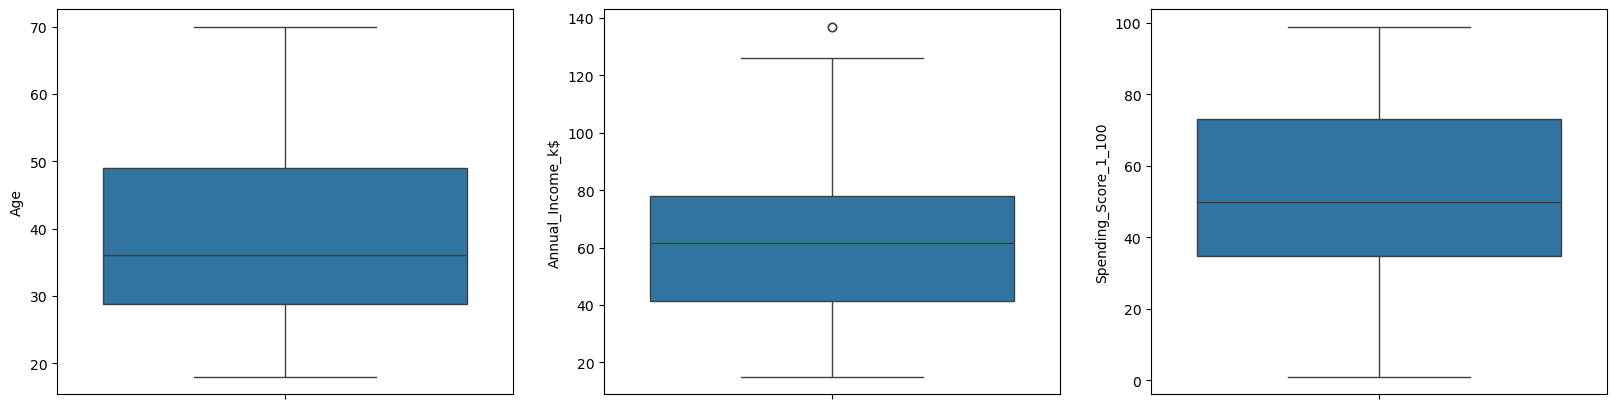


Age, Annual_Income and Spending_Score are not normally distributed, but do not have outliers => can use MinMaxScaler


In [6]:
from scipy.stats import shapiro
print(f'Normality test of Age: {shapiro(shopping['Age'])}')
print(f'Normality test of Annual_Income: {shapiro(shopping['Annual_Income_k$'])}')
print(f'Normality test of Spending_Score: {shapiro(shopping['Spending_Score_1_100'])}')

print()

plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
sbn.boxplot(data = shopping, y = 'Age')
plt.subplot(1,3,2)
sbn.boxplot(data = shopping, y = 'Annual_Income_k$')
plt.subplot(1,3,3)
sbn.boxplot(data = shopping, y = 'Spending_Score_1_100')
plt.show()

print('\nAge, Annual_Income and Spending_Score are not normally distributed, but do not have outliers => can use MinMaxScaler')

## <span style = 'color : yellow'> Build DBSCAN model to cluster data (use silhoutte score to examine good epsilon)

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from imblearn.pipeline import Pipeline

eps = []
minPts = []
silh_score = []

for epsilon in np.arange(0.1, 0.5, 0.005):
    for min_points in np.arange(3, 15, 1):
        dbscan_pipe = Pipeline([
            ('Encoder', make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), ['Genre']), remainder='passthrough')),
            ('Scaler', MinMaxScaler()),
            ('DBSCAN', DBSCAN(eps=epsilon, min_samples=min_points))
        ])
        data = shopping.drop('CustomerID', axis = 1)
        dbscan_pipe.fit(data)
        labels = dbscan_pipe.fit_predict(data)

        col_names = dbscan_pipe.named_steps['Encoder'].get_feature_names_out()

        data_evaluate = (
            pd.DataFrame(dbscan_pipe[:-1].transform(data), columns=col_names)
            .assign(Group = labels)
            .pipe(lambda df: df[df['Group'] != -1])
                )
                
        eps.append(epsilon)
        minPts.append(min_points)
        
        if data_evaluate.empty or data_evaluate['Group'].nunique() < 2:
            silh_score.append('Not_enough_cluster_for_scoring')
            continue
        else:
            labels = data_evaluate['Group']
            data_evaluate = data_evaluate.drop('Group', axis = 1)
            silh_score.append(silhouette_score(data_evaluate, labels))

df_eps_minPts_score = pd.DataFrame({
    'epsilon':eps,
    'min_points_samples':minPts,
    'silhoutte_score': silh_score
})

print(df_eps_minPts_score[df_eps_minPts_score['silhoutte_score'] == 'Not_enough_cluster_for_scoring'].head())

df_final_score = (
    df_eps_minPts_score[df_eps_minPts_score['silhoutte_score'] != 'Not_enough_cluster_for_scoring']
    .sort_values(by='silhoutte_score', ascending=False)
)

print()
print(df_final_score)

   epsilon  min_points_samples                 silhoutte_score
4      0.1                   7  Not_enough_cluster_for_scoring
5      0.1                   8  Not_enough_cluster_for_scoring
6      0.1                   9  Not_enough_cluster_for_scoring
7      0.1                  10  Not_enough_cluster_for_scoring
8      0.1                  11  Not_enough_cluster_for_scoring

     epsilon  min_points_samples silhoutte_score
17     0.105                   8        0.801988
42     0.115                   9        0.780358
67     0.125                  10        0.777466
80     0.130                  11        0.776183
117    0.145                  12        0.747973
..       ...                 ...             ...
216    0.190                   3        0.185855
204    0.185                   3        0.185855
168    0.170                   3        0.184193
180    0.175                   3        0.139741
192    0.180                   3        0.111159

[911 rows x 3 columns]


In [37]:
dbscan_pipe = Pipeline([
    ('Encoder', make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), ['Genre']), remainder='passthrough')),
    ('Scaler', MinMaxScaler()),
    ('DBSCAN', DBSCAN(eps=0.105, min_samples=8))
])
data = shopping.drop('CustomerID', axis = 1)
dbscan_pipe.fit(data)
labels = dbscan_pipe.fit_predict(data)

col_names = dbscan_pipe.named_steps['Encoder'].get_feature_names_out()

data_clustered = (
    data.pipe(lambda df: pd.DataFrame(dbscan_pipe.named_steps['Encoder'].transform(df), columns= col_names))
    .assign(Group = labels)
    .pipe(lambda df: df.set_axis(
        df.columns.str.replace('onehotencoder__', '', regex=False).str.replace('remainder__', '', regex=False),
        axis=1
    ))
)

#print(f"All groups' labels:\n {data_clustered['Group'].value_counts()}")

print()
print(data_clustered)


     Genre_Male   Age  Annual_Income_k$  Spending_Score_1_100  Group
0           1.0  19.0              15.0                  39.0     -1
1           1.0  21.0              15.0                  81.0     -1
2           0.0  20.0              16.0                   6.0     -1
3           0.0  23.0              16.0                  77.0     -1
4           0.0  31.0              17.0                  40.0     -1
..          ...   ...               ...                   ...    ...
195         0.0  35.0             120.0                  79.0     -1
196         0.0  45.0             126.0                  28.0     -1
197         1.0  32.0             126.0                  74.0     -1
198         1.0  32.0             137.0                  18.0     -1
199         1.0  30.0             137.0                  83.0     -1

[200 rows x 5 columns]


## <span style = 'color : yellow'> Report clustering results

In [40]:
data_group = data_clustered.copy()

for group in data_group['Group'].unique():
    print(f'\n=============== Cluster group {group} =========================\n')
    data = data_group[data_group['Group'] == group]
    
    print(f'n_observations: {data.shape[0]}\n')
    
    for col_name in data.columns[:-1]:
        if col_name in ['Genre_Male']:
            print(f'{data[col_name].value_counts().to_frame().reset_index()}')
            print()
        else:
            print(f'{col_name}: {np.min(data[col_name])} ~ {np.median(data[col_name])} ~ {np.max(data[col_name])}')
            print()


=============== Cluster group -1 =========================

n_observations: 183

   Genre_Male  count
0         0.0     95
1         1.0     88

Age: 18.0 ~ 36.0 ~ 70.0

Annual_Income_k$: 15.0 ~ 61.0 ~ 137.0

Spending_Score_1_100: 1.0 ~ 50.0 ~ 99.0


=============== Cluster group 0 =========================

n_observations: 9

   Genre_Male  count
0         0.0      9

Age: 43.0 ~ 47.0 ~ 51.0

Annual_Income_k$: 48.0 ~ 54.0 ~ 67.0

Spending_Score_1_100: 42.0 ~ 46.0 ~ 53.0


=============== Cluster group 1 =========================

n_observations: 8

   Genre_Male  count
0         0.0      8

Age: 27.0 ~ 30.0 ~ 32.0

Annual_Income_k$: 70.0 ~ 78.0 ~ 88.0

Spending_Score_1_100: 73.0 ~ 84.5 ~ 89.0



Number of numeric fields: 3

All numeric fields: ['Age', 'Annual_Income_k$', 'Spending_Score_1_100']



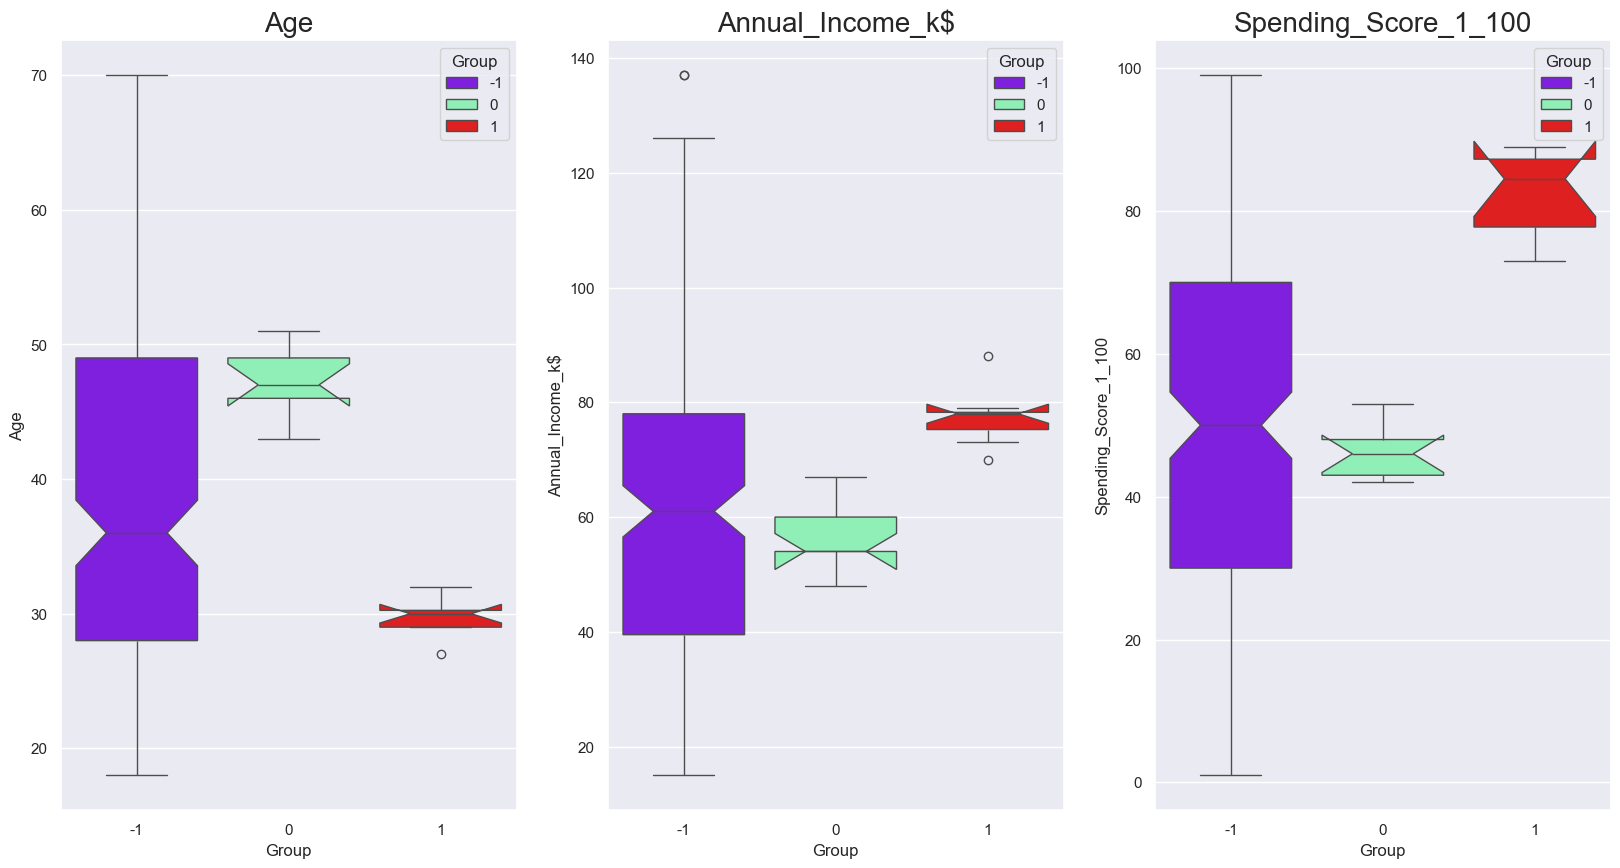


-----------------------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------------------------

Number of categorical fields: 1

All categorical fields: ['Genre_Male']



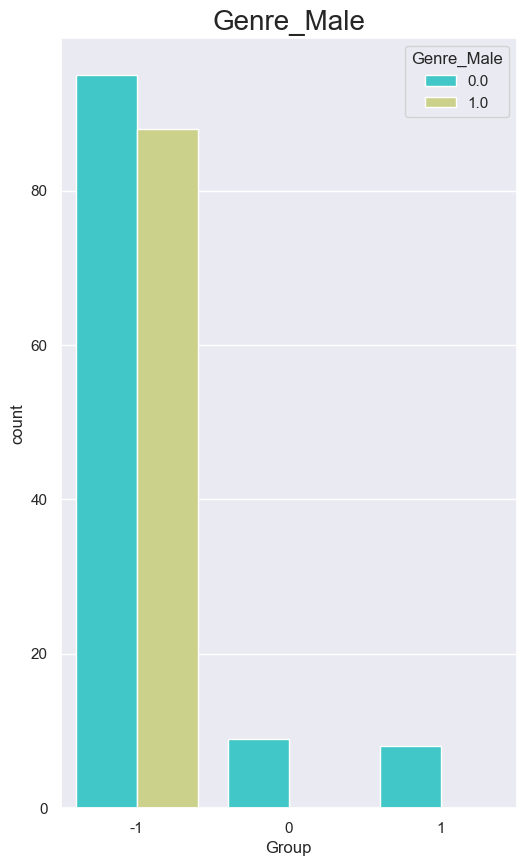

In [42]:
data_group = data_clustered.copy()

numeric_cols = ['Age', 'Annual_Income_k$',  'Spending_Score_1_100']
categ_cols = ['Genre_Male']

##### Function building ##############

def boxplot_numeric(df, numeric_cols, figsize=(20, 10), groups = None):
    col = 3
    if (len(numeric_cols) % 3) == 0:
        row = len(numeric_cols) // 3
    else:
        row = (len(numeric_cols) // 3) + 1
    '''
    numeric_cols: list các tên cột biến định lượng
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    groups: tên cột chứa biến phân nhóm như 'Group' hoặc 'Class' hoặc 'Label'
    '''
    print(f'Number of numeric fields: {len(numeric_cols)}')
    print()
    print(f'All numeric fields: {numeric_cols}')
    print()
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        sbn.boxplot(data = df, x = groups, y = numeric_cols[i-1], notch = True, hue = groups, palette = 'rainbow')
        plt.title(numeric_cols[i-1], size = 20)
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break
    plt.show()


def countplot_categ(df, categ_cols, figsize=(20, 10), groups = None):
    col = 3
    if (len(categ_cols) % 3) == 0:
        row = len(categ_cols) // 3
    else:
        row = (len(categ_cols) // 3) + 1
    '''
    categ_cols: list các tên cột biến định tính
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    groups: tên cột chứa biến phân nhóm như 'Group' hoặc 'Class' hoặc 'Label'
    '''
    print(f'Number of categorical fields: {len(categ_cols)}')
    print()
    print(f'All categorical fields: {categ_cols}')
    print()
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    for i in range(1, len(categ_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        sbn.countplot(data = df, x = groups, hue = categ_cols[i-1], palette = 'rainbow')
        plt.title(categ_cols[i-1], size = 20)
      except:
        print('Error {}'.format(categ_cols[i-1]))
        break
    plt.show()

## Draw
sbn.set_theme(style ='darkgrid')
boxplot_numeric(data_group, numeric_cols, groups = data_group.iloc[:,-1])
print('\n-----------------------------------------------------------------------------------------------------------------------------\n'*2)
countplot_categ(data_group, categ_cols, groups = data_group.iloc[:,-1])